# 04 - Training Models

In [1]:
# -- Setup -- #

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures (not done in Ch. 02-03)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear Regression

Linear regression model prediction

$$\hat{\bf{y}} = h_\theta(\bf x) = \bf{\theta}^T \bf{x}$$

$\theta$ : *parameter vector*, bias term $\theta_0$\n

$\bf x$ : *feature vector*, $x_0 = 1$

$h_\theta$ : *hypothesis fn*, w/ model params $\theta$

MSE of a Linear Regression hypothesis $h_\theta$ on a training set $\bf X$

$$MSE(\theta) = \frac1m \sum_m \left( \theta^T\bf{x^{(i)}} - y^{(i)}\right)^2$$

### The Normal Equation

Closed form solution for $\theta$

$\hat{\bf{\theta}} = (\bf{X}^T\bf X)^{-1} \bf{X}^T y$

Let's generate some 'linear' data to test regression upon.

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


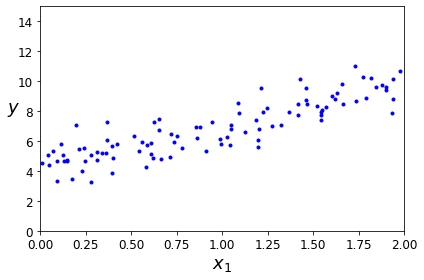

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Compute $\hat \theta$ using normal eq. Use `inv` from `np.linalg`

In [8]:
# Form x_0 component
X_b = np.c_[np.ones((100, 1)), X] # np.c_ translates slice objs to concat. along second axis
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

Note model is $y = 4 + 3x + \epsilon$, w/ $\epsilon$ normally distributed. We see we get close to expected params

In [9]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [10]:
# Make predictions
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best) # hypothesis fn.
y_predict

array([[4.21509616],
       [9.75532293]])

Saving figure linear_model_predictions_plot


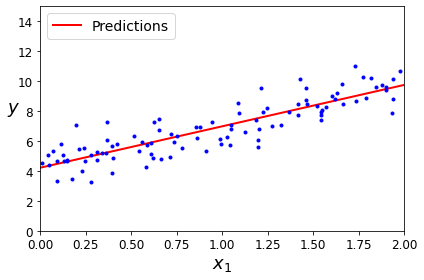

In [14]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

Lin. Reg. is easily implemented in sklearn

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [16]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In fact, `LinearRegression` is based upon `scipy.linalg.lstsq()`

In [17]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

`lstsq` computes the *psuedo inverse* $\bf{X}^+$ within $\hat\theta = \bf X^\dagger \bf y$. Psuedo inv. can be directly calculated via `np.linalg.pinv`. Details not too important but psuedo inverse is more computationally efficient (from matrix factorization via SVD Singular Value Decomposition) and robust in comparison to normal eq.

In [18]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

### Computational Complexity

As alluded to above, the normal eqn, computing inverse of $\bf X^T \bf X$ is $\mathcal O(n^{2.4})$ - $\mathcal O(n^3)$. SVD approach is $\mathcal O(n^2)$. Worth noting that both are $\mathcal O(m)$ where $m$ is size of traning set. When training set size or number of features are too large, need iterative method like grad. descent.

## Gradient Descent

Tweak params iteratively to minimize cost fn. Initially randomized. 'Learning step' size is proportional to slope, so steps get smaller as minimum is approached. If learning rate is too large, may jump over minimum and diverge. See Fig 4-6, which shows generic problem of avoiding local min and also points out long time consumption at inflection plateaus.

MSE in particular is convex, continuous, *Lipschitz* continuous derivative. Thus grad. desc. is guaranteed to approach global min asymptotically (if learning rate not too high). In 2D, cost fn is elliptical bowl. As in FIg. 4-7, features with different scales take longer to converge (circular vs elliptical). I believe this is a result of a fixed learning rate. Adaptive should help. 

### Batch Gradient Descent

$\frac{\partial}{\partial \theta_j}MSE(\theta) = \frac{2}{m} \sum_i (\theta^T\bf x^{(i)}- y^{(i)})x^{(i)}_j$

As a single vector

$\nabla_\theta MSE = \frac{2}{m}\bf X^T(\bf X \theta - \bf y)$

Since the gradient is evaluated on the entire $\bf X$ (each step), this is why is considered *batch* gradient descent. Scales well with number of features (as compared to normal eq. or SVD)

Gradient Descent Step

$\theta^{(next\ step)} = \theta - \eta \nabla_\theta MSE(\theta)$

In [26]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [30]:
theta #matches normal eq. result

array([[4.21509616],
       [2.77011339]])

In [31]:
X_new_b.dot(theta)
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


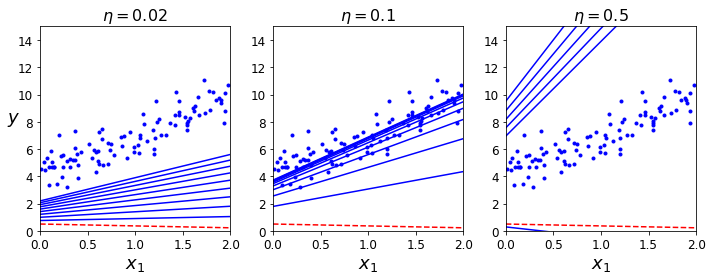

In [24]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

Different learning rates pictured above (starting with dashed red). Can use grid search to find proper learning rate. Number of iterations best terminated based on tolerance $\epsilon$ of norm of gradient vector. Author suggests (with linear regression) that convergence time is $\mathcal O(1/\epsilon)$

### Stochastic Gradient Descent

### Mini-batch Gradient Descent

## Polynomial Regression

## Learning Curves

## Regularized Linear Model

### Ridge Regression 

### Lasso Regression

### Elastic Net

### Early Stopping

## Logistic Regression

### Estimating Probabilities

### Training and Cost Function

### Decision Boundaries

### Softmax Regression